In [ ]:
import os
import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix


BERT_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


EPOCHS = 1
MAX_TOKEN_COUNT = 512
BATCH_SIZE = 32

In [ ]:
from torch.cuda.amp import autocast as autocast
from torch.cuda.amp import GradScaler as GradScaler

In [ ]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(20)

In [ ]:
%%time 
train_df=pd.read_feather("Hierarchical major.feather")
val_df=pd.read_feather("./autodl-nas/CoPatE/USPTO-2M_Validation.feather")

LABEL_COLUMNS=train_df.columns[11:]
LABEL_COLUMNS

In [ ]:
LABEL_COLUMNS=train_df.columns[11:-139]
LABEL_COLUMNS

In [ ]:
test_df = pd.read_feather("Test.feather")

In [ ]:
LABEL_COLUMNS=test_df.columns[11:-7]
LABEL_COLUMNS

In [ ]:
class PatentDataset(Dataset):
    """
    Pass pandas dataframe, and tokeizer along with the max token length[128 default]
    
    Example: 
    -------
    train_dataset = ToxicCommentsDataset(
      train_df,
      tokenizer,
      max_token_len=MAX_TOKEN_COUNT
    )

    sample_item = train_dataset[0]
    
    """
    
    
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: BertTokenizer,
        max_token_len: int = 512,
        test= False
    ):
        self.data = data
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        self.test = test
        
    
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        comment_text = "".join(data_row.claims)

        if not self.test:
            labels = data_row[LABEL_COLUMNS]
        
        encoding = self.tokenizer.encode_plus(
            comment_text,
            max_length=self.max_token_len,
            padding="max_length",
            truncation=True,
            add_special_tokens=True, # [CLS] & [SEP]
            return_token_type_ids=False,
            return_attention_mask=True, #attention_mask
            return_tensors='pt',
        )
        
        if not self.test:
            return dict(
            comment_text=comment_text,
            input_ids = encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            labels=torch.FloatTensor(labels)
        )
        else:
            return dict(
                comment_text=comment_text,
                input_ids = encoding["input_ids"].flatten(),
                attention_mask=encoding["attention_mask"].flatten()
            )
        

In [ ]:
train_dataset = PatentDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

val_dataset = PatentDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,drop_last = True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last = True)

In [ ]:
class PatentTagger(nn.Module):

    def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True) #load the pretrained bert model
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes) # add a linear layer to the bert
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCEWithLogitsLoss()
        self.dropout = nn.Dropout(self.bert.config.hidden_dropout_prob)
        
    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(self.dropout(output.last_hidden_state[:,0])) 
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output

In [ ]:
model = PatentTagger(len(LABEL_COLUMNS)).to(device)

N_EPOCHS = 1

steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS
warmup_steps = total_training_steps // 10
warmup_steps, total_training_steps

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_training_steps
)

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score

# function for evaluating the model
def evaluate(mydataloader):

    print("\nEvaluating...")
    #t0 = time.time()
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []
    total_labels = []

    # iterate over batches
    for step,batch in tqdm(enumerate(mydataloader),total=len(mydataloader)):

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)   

        with autocast():
            with torch.no_grad():
                loss, outputs = model(input_ids, attention_mask, labels)
                outputs = torch.sigmoid(outputs)
                
        total_loss = total_loss + loss.float().item()
        outputs = outputs.detach().float().cpu().numpy()
        labels = labels.detach().float().cpu().numpy()
        total_preds.append(outputs)
        total_labels.append(labels)

    avg_loss = total_loss / len(mydataloader)

    total_preds  = np.concatenate(total_preds, axis=0)
    total_labels = np.concatenate(total_labels, axis=0)

    print(f"Evaluate loss {total_loss / len(mydataloader)}")
    model.train()
    return avg_loss, total_preds, total_labels

In [ ]:
# function to train the model
def train():
    
    now=time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
    best_valid_loss = float('inf')
    model.train()

    total_loss, total_accuracy = 0, 0
    avg_loss = 0
    scaler = GradScaler()
   
    # iterate over batches
    for step,batch in tqdm(enumerate(train_dataloader),total=len(train_dataloader),desc="Train"):
        
        if step%10000 == 0 and step!=0:
            valid_loss,_,_ = evaluate(val_dataloader)
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), f"./model/BERT-first512.pt")

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)     

        model.zero_grad() 
        with autocast():
            loss, _ = model(input_ids, attention_mask, labels)
            
        
        scaler.scale(loss).backward()
        
        if step%100 == 0 :
            print(f"step: {step} loss: {loss}")
            losses.append(loss.float().cpu())
        # add on to the total loss
        total_loss = total_loss + loss.float().item()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scheduler.step()
        scaler.update()

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    return avg_loss

In [ ]:
import time
from tqdm.auto import tqdm
losses = []

now=time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
print(now)
train_loss = train()

In [44]:
losses = [t.detach().numpy() for t in losses]

In [17]:
import matplotlib.pyplot as plt

In [46]:
d=pd.read_csv("losses_Tags.csv")

In [50]:
losses_tags = d['0'].to_numpy()

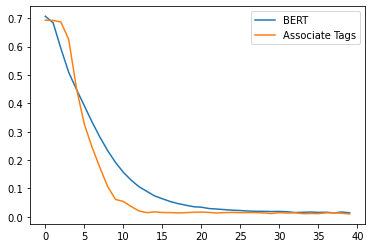

In [56]:
plt.plot(losses[:40],label='BERT')
plt.plot(losses_tags[:40],label='Associate Tags')
plt.legend()
plt.savefig("losses.png",dpi=200)
plt.show()

In [57]:
d = pd.DataFrame(losses)

In [59]:
d.to_csv("losses.csv")

In [21]:
with open("untitled.txt",'r') as fr:
    data = fr.readlines()

In [22]:
data = [x.split(":")[1][:-2] for x in data]

In [23]:
data =[ float(x) for x in data]

In [24]:
data = np.array(data)

No handles with labels found to put in legend.


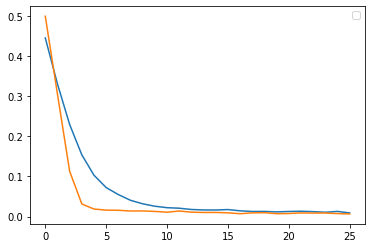

In [34]:
plt.plot(losses[2:28])
plt.plot(data[2:28])
plt.legend()

## 测试

In [15]:
model.load_state_dict(torch.load("./model/Classfication_abstract_model2022-05-01 16:44:28.pt"))

<All keys matched successfully>

In [14]:
valid_loss,total_preds,total_labels = evaluate(val_dataloader)


Evaluating...



Evaluate loss 0.005177605530700785


In [15]:
from sklearn.metrics import accuracy_score, roc_curve, auc,precision_score
import matplotlib.pyplot as plt

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs#[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    precision = precision_score(y_true,y_pred)
    print(f'Precision: {precision*100:.2f}%')
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [16]:
from sklearn.metrics import roc_auc_score
# function for evaluating the model
def evaluate(mydataloader):

    print("\nEvaluating...")
    #t0 = time.time()
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []
    total_labels = []

    # iterate over batches
    for step,batch in tqdm(enumerate(mydataloader),total=len(mydataloader)):

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)   
        # deactivate autograd
        with torch.no_grad():
            
            loss, outputs = model(input_ids, attention_mask, labels)

            total_loss = total_loss + loss.item()

            outputs = outputs.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            total_preds.append(outputs)
            total_labels.append(labels)


    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)
    print(f"{step}: {avg_loss}")



    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    total_labels = np.concatenate(total_labels, axis=0)
    true = np.array(total_labels)
    pred = np.array(total_preds>0.5)
    #print(true)
    #print(pred)
    for i, name in enumerate(LABEL_COLUMNS):
        try:
            print(f"{name} roc_auc {roc_auc_score(true[:, i], pred[:, i])}")
        except Exception as e:
            print(e)
            pass
    print(f"Evaluate loss {total_loss / len(val_dataloader)}")
    
    
    total_patent=0
    acc_patent=0
    for pp,pr in zip(pred,true):
        total_patent+=1
        if all(pp==pr):
            acc_patent+=1
    print(f"Predict accuracy num: {acc_patent},total Patent num: {total_patent}, Accuracy: {acc_patent/total_patent*100:.2f}%")
    
    return avg_loss, total_preds, total_labels

In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)


true = np.array(total_labels)
pred = np.array(total_preds>0.5)

dic = {
    "Accuracy" : accuracy_score(true,pred),
    "Precision-micro" : precision_score(true,pred,average='micro'),
    "Precision-macro" : precision_score(true,pred,average='macro'),
    "recall-micro" : recall_score(true,pred,average='micro'),
    "recall-macro" : recall_score(true,pred,average='macro'),
    "f1_micro" : f1_score(true,pred,average='micro'),
    "f1-macro" : f1_score(true,pred,average='macro')
}

/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [20]:
# Test-A 5000 scores
dic

{'Accuracy': 0.3754111842105263,
 'Precision-micro': 0.7974184295446397,
 'Precision-macro': 0.3862186383017146,
 'recall-micro': 0.4965394061174369,
 'recall-macro': 0.23593060096168625,
 'f1_micro': 0.6119977985690699,
 'f1-macro': 0.27780302660087103}

In [43]:
# Test-A 50000 scores
dic

{'Accuracy': 0.37504006410256413,
 'Precision-micro': 0.7994232005420525,
 'Precision-macro': 0.4782887336596196,
 'recall-micro': 0.4998533485416327,
 'recall-macro': 0.23880155245503887,
 'f1_micro': 0.6151028647051746,
 'f1-macro': 0.3018871559205054}

In [20]:
# Test 2021-A scores
# learning_rate 5e-5
dic

NameError: name 'dic' is not defined

In [26]:
# Test 2021-A scores
# learning_rate 5e-5
dic

{'Accuracy': 0.3426790557199211,
 'Precision-micro': 0.8687377221435424,
 'Precision-macro': 0.3707975747138592,
 'recall-micro': 0.3982917010518731,
 'recall-macro': 0.1260669178061862,
 'f1_micro': 0.5461767797749323,
 'f1-macro': 0.17230378630870097}

In [32]:
# Test 2021-A-50000 scores
# learning_rate 5e-5
dic

{'Accuracy': 0.3416666666666667,
 'Precision-micro': 0.8671591098021518,
 'Precision-macro': 0.3461082396608983,
 'recall-micro': 0.3967615735709628,
 'recall-macro': 0.12544875490870652,
 'f1_micro': 0.5444256391521215,
 'f1-macro': 0.17069473713464509}

In [21]:
torch.save(model.state_dict(), f"./baseline-Classification-USPTO-2M{now}.pt")

In [38]:
# Test 2021-A
test_df = pd.read_feather("./2021-sample-50000.feather")

In [16]:
test_dataset = PatentDataset(
  test_df,
  tokenizer,
  max_token_len=128
)

In [17]:
test_dataloader = DataLoader(test_dataset, batch_size=8*BATCH_SIZE, shuffle=True,drop_last = True)

In [41]:
avg_loss, total_preds, total_labels = evaluate(test_dataloader)


Evaluating...


  0%|          | 0/195 [00:00<?, ?it/s]

Evaluate loss 0.005641902016045955


In [18]:
avg_loss, total_preds, total_labels = evaluate(test_dataloader)


Evaluating...


  0%|          | 0/19 [00:00<?, ?it/s]

Evaluate loss 0.005589187954013285


In [22]:
total_labels = torch.tensor(total_labels)
total_preds = torch.tensor(total_preds)

In [24]:
preds = torch.argmax(total_preds,dim=1,keepdim=True)

In [25]:
tp = 0
fp = 0
total = total_labels.shape[0]
ls = []

for i in range(total_labels.shape[0]):
    label = torch.where(total_labels[i])
    pr = 1
    for l in label[0]:
        if l == preds[i]:
            tp += 1
            break
    else:
        pr = 0
    ls.append(pr/label[0].shape[0])
    
precision = tp/total
recall = np.mean(ls)
f1_score = 2*precision*recall / (precision+recall)
print(precision)
print(recall)
print(f1_score)

0.8050986842105263
0.5528234649122807
0.6555271883430036
